In [7]:
box = 'Box_n50_0_1400'
param_names = ['d','e','f','g']
ndim = len(param_names)
wprior = 1
a_fit = 0.866399


In [8]:
from utils import *
from massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [9]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [10]:
cosmo = cosmo_params[box]
mass_function = MassFunction(cosmo)

In [11]:
h = cosmo['H0']/100

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [12]:
all_as = list(NvMs.keys())
all_zs = list(map(scaleToRedshift, all_as))
print(all_as)
print(all_zs)

[0.25, 0.302679, 0.366459, 0.403224, 0.488191, 0.512095, 0.537169, 0.563471, 0.591061, 0.620002, 0.65036, 0.715608, 0.787402, 0.866399, 0.953321, 1.0]
[3.0, 2.3038301302700224, 1.7288182306888356, 1.4800111104497748, 1.0483786059144884, 0.9527626709887815, 0.8616115226306804, 0.7747142266416549, 0.691872750866662, 0.6128980229096033, 0.5376099391106464, 0.3974131088528914, 0.26999931420037027, 0.15420262488760939, 0.04896461947234987, 0.0]


In [23]:
prev_a = -1
prev_box = -1
if(wprior):
    prev_a = all_as[all_as.index(a_fit)+1]
    prev_box = 
    print('Prev Scale is %.2f'%(prev_a))

Prev Scale is 0.95


In [14]:
N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline


vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm([a_fit]):
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/1 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and cal

In [15]:
a_list = list(NvMs.keys())

from scipy.stats import poisson


M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [16]:
jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a]) for a in weighted_cov}  

scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}

In [17]:
def uniform_log_prior(param_values):
    #uniform prior
    for param in param_values:
        if(param < 0 or param > 5):
            return -np.inf
    return 0

In [18]:
def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(uniform_log_prior(param_values) == -np.inf):
        return -np.inf

    params = dict(zip(param_names, param_values))

    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [mass_function.tinker(a, M_c, **params)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
        if(scaleToRedshift(a) >=2):
            continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (len(inv_weighted_cov)* np.log(2*np.pi) + 
                          np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + 
                          scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)


In [19]:
def log_likelihood(param_values):
    lp = uniform_log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [20]:

def log_prior(param_values):
    
    xmp = param_values - prev_final_param_vals
    arg = np.dot(np.dot(xmp.T, KXinv), xmp)
    return -1/2*(ndim * np.log(2*np.pi) + logdetKX + arg)
def log_likelihood_with_prior(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [43]:
prev_sampler = None
prev_final_param_vals = np.random.uniform(low=0, high=5, size=(len(param_names)))
if(wprior):
    #if we have a prior from lower redshift we use
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_MCMC_sampler.pkl"%(box, prev_a), "rb") as f:
        prev_sampler = pickle.load(f)
    samples = prev_sampler.chain[:, 500:, :].reshape((-1, ndim))
    prev_final_param_vals = np.percentile(samples,  50,axis=0)
    
prev_params_final = dict(zip(param_names, prev_final_param_vals))
PARAM_SPREAD = 0.001
KX = np.diag([PARAM_SPREAD for _ in range(ndim)])
KXinv = np.linalg.inv(KX)
detKX = np.linalg.det(KX)
logdetKX = np.log(detKX)

We'll use the parameters obtained for previous redshift as prior for current redshift. Let $p$ be the previous parameters and $n$ be the number of parameters. The prior is then 
$$P(x) = \frac 1 {\left[(2 \pi)^{n} {\rm det}K_x\right]^{1/2}}\times {\rm exp} \left\{-\frac 1 2 (x-p)\cdot K_x^{-1} \cdot (x-p) \right\} $$
$$\Rightarrow \log P(x) = -\frac 1 2 \left(\ln {\rm det} K_x  + (x-p)\cdot K_x^{-1}\cdot (x-p)\right)$$
We will set $K_X$ by hand as $K_X={\rm diag}(0.1, 0.1, 0.1, 0.1)$ (pulled out of a hat but roughly seems appropriate to assert smooth varying as function of redshift

In [44]:
def get_guess_wprior():
    return prev_final_param_vals + np.random.normal(loc=0, scale=PARAM_SPREAD, size=prev_final_param_vals.shape)
def get_guess():
    return np.random.uniform(low=0, high=5, size=(len(param_names)))

fguess = get_guess_wprior if wprior else get_guess
guess = fguess()
while(not np.isfinite(log_likelihood_with_prior(guess))):
    guess = fguess()

In [45]:
print('Starting ML Fit')
#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood_with_prior(*args) if wprior else -log_likelihood(*args)
result = optimize.minimize(nll, guess, method="Nelder-Mead", options={
    'maxiter': len(guess)*10000
})
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

Starting ML Fit
Box_n50_0_1400
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1939.096176956701
             x: [ 4.863e-01  8.529e-01  2.181e+00  1.269e+00]
           nit: 143
          nfev: 251
 final_simplex: (array([[ 4.863e-01,  8.529e-01,  2.181e+00,  1.269e+00],
                       [ 4.862e-01,  8.528e-01,  2.181e+00,  1.269e+00],
                       ...,
                       [ 4.863e-01,  8.529e-01,  2.181e+00,  1.269e+00],
                       [ 4.862e-01,  8.528e-01,  2.181e+00,  1.269e+00]]), array([ 1.939e+03,  1.939e+03,  1.939e+03,  1.939e+03,
                        1.939e+03]))
   param_names: ['d', 'e', 'f', 'g']
[0.48625228 0.85290559 2.18094589 1.2687531 ]


In [46]:
MLE_params = dict(zip(param_names, result['x']))
print(MLE_params)

{'d': 0.48625228441174406, 'e': 0.8529055863692204, 'f': 2.180945891711799, 'g': 1.268753100127206}


In [47]:
prev_params_final

{'d': 0.516504389179002,
 'e': 1.004779877737438,
 'f': 2.270812460913173,
 'g': 1.2921011028078735}

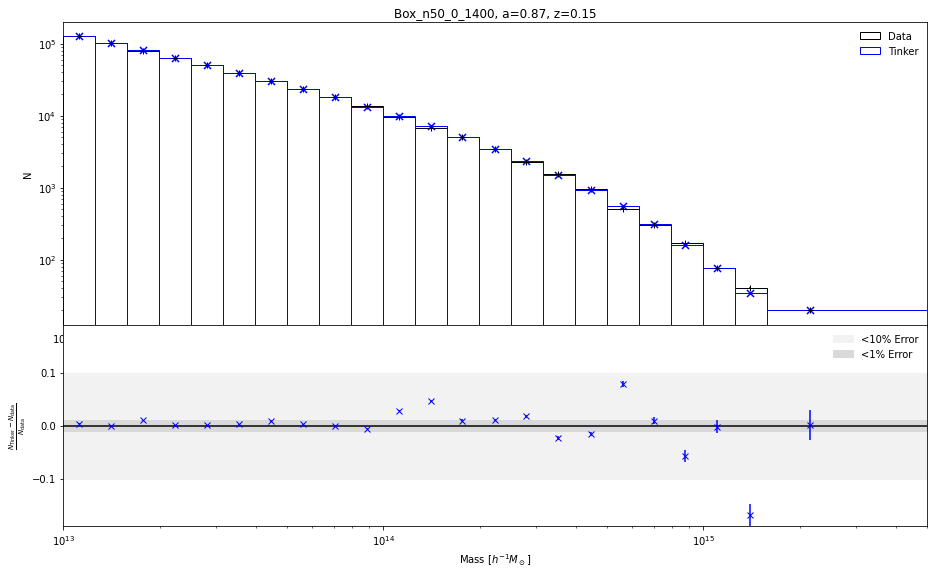

In [48]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
c_params = MLE_params
a = a_fit

fig1 = plt.figure(figsize =(12, 7))

axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
plt.subplots_adjust(wspace=0, hspace=0)
Pk = mass_function.Pka[a]
c_data = NvMs[a]

Ms = M_data[a]
N = N_data[a]
edge_pairs = c_data['edge_pairs']

edges = [edge[0] for edge in edge_pairs]
edges += [edge_pairs[-1][1]]

yerr = yerr_dict[a]
dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


tinker_eval_MCMC = [mass_function.tinker(a, M_c, **c_params)*vol for M_c in M_numerics]
f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])



axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

edges = np.array(edges)
axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

y1 = 0.1*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.1*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

c_Ms = np.append(Ms, edges[-1])
c_Ms = np.append(edges[0], c_Ms)
axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

y1 = 0.01*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.01*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(frameon=False)
axs[0].set_ylabel('N')

axs[1].set_xscale('log')
# axs[1].set_yscale('lin', linthresh=1e-2)    
axs[1].legend(frameon=False)
axs[1].axhline(0, c='black')
axs[1].set_ylabel('N')
axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

axs[0].set_xlim((1e13, np.max(edges)))
axs[1].set_xlim((1e13, np.max(edges)))
axs[1].set_ylim((-.19, .19))
axs[1].set_yticks([-.1, 0, .1])


In [32]:
nwalkers = 64
ndim = len(param_names)

initialpos = np.array([result['x'] for _ in range(nwalkers)]) + 1e-2 * np.random.normal(size=(nwalkers, ndim))


from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood_with_prior,
    pool=Pool()
)

sampler.run_mcmc(initialpos, 1000, progress=True);

100%|██████████| 1000/1000 [02:18<00:00,  7.23it/s]


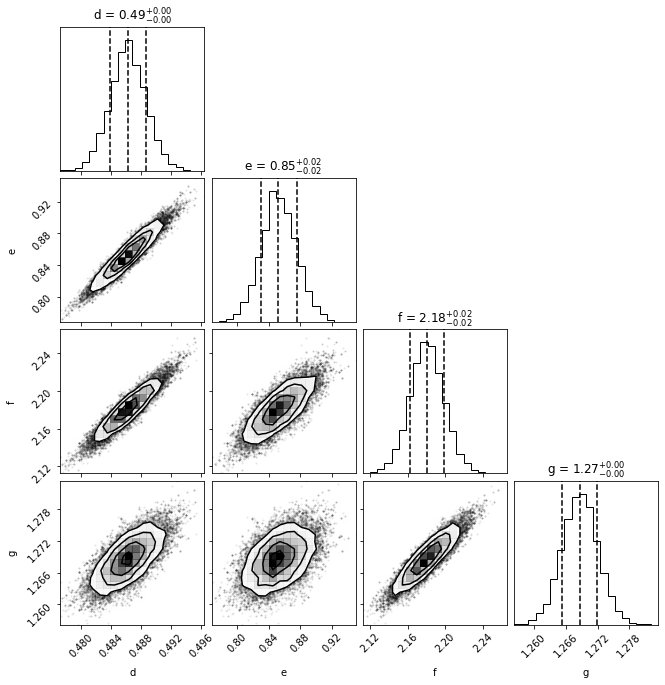

In [33]:
labels = param_names

import corner
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final = dict(zip(param_names, final_param_vals))
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

# plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_corner.pdf'%(box), bbox_inches='tight')

(1000, 64, 4)


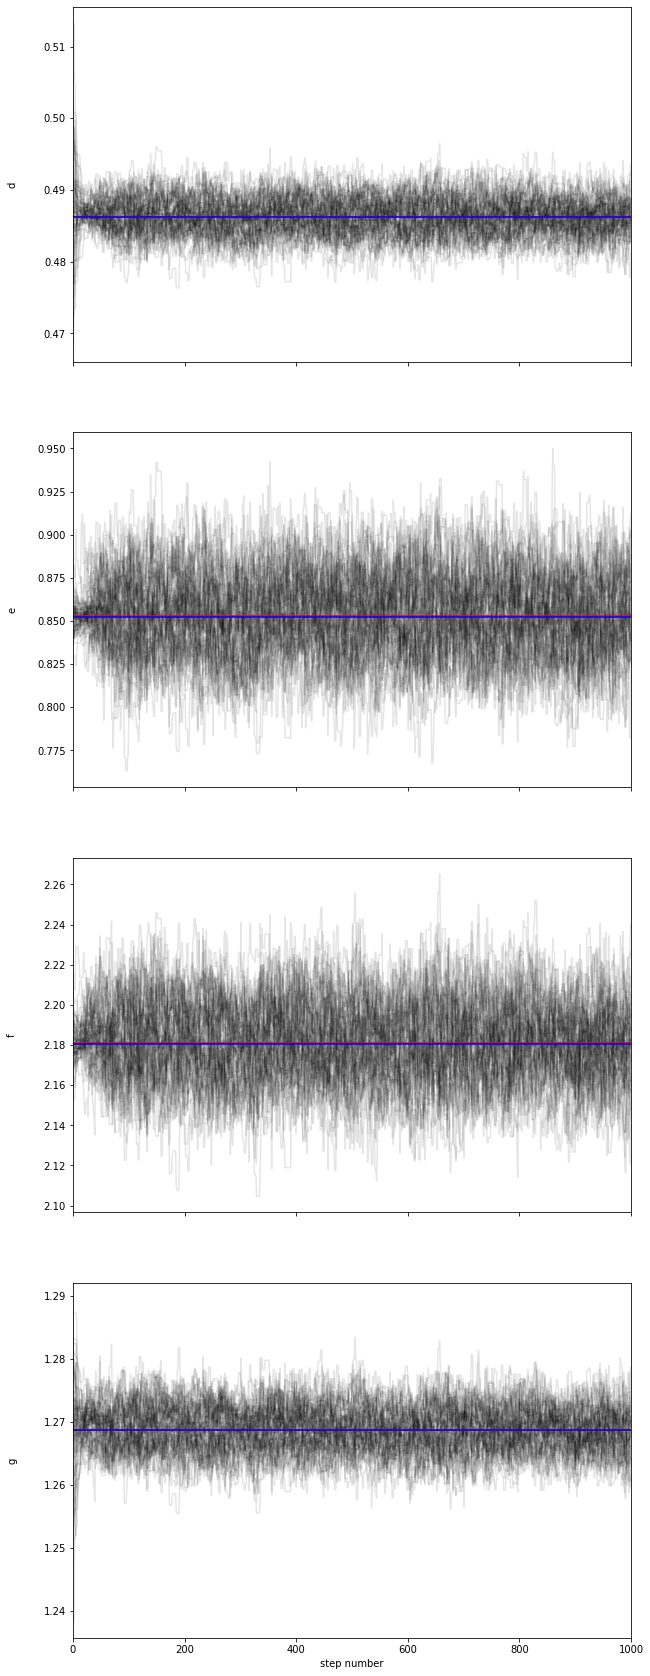

In [34]:
labels = param_names

fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
print(np.shape(samples))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(result['x'][i], color='red')
    ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");

# plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_convergence.pdf'%(box), bbox_inches='tight')

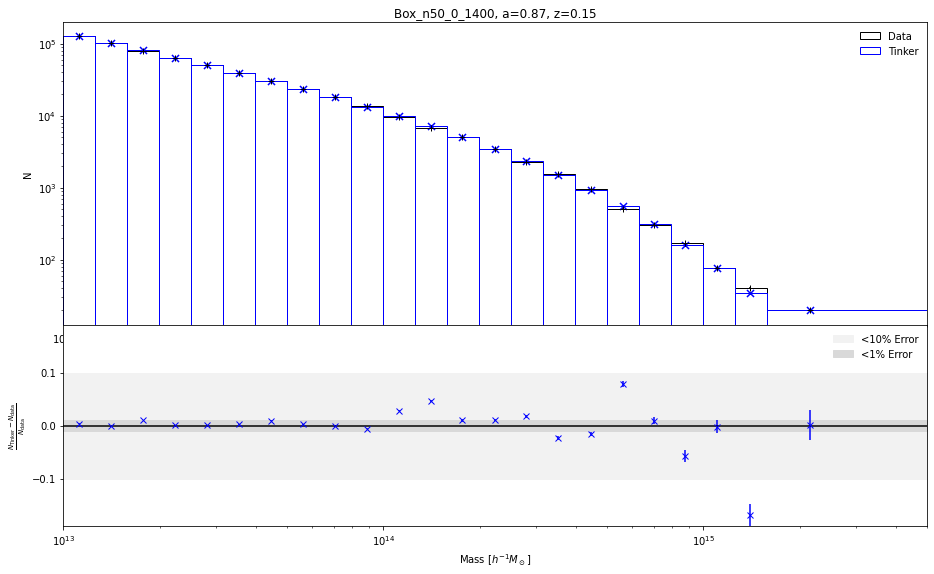

In [35]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
c_params = params_final
a = a_fit

fig1 = plt.figure(figsize =(12, 7))

axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
plt.subplots_adjust(wspace=0, hspace=0)
Pk = mass_function.Pka[a]
c_data = NvMs[a]

Ms = M_data[a]
N = N_data[a]
edge_pairs = c_data['edge_pairs']

edges = [edge[0] for edge in edge_pairs]
edges += [edge_pairs[-1][1]]

yerr = yerr_dict[a]
dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


tinker_eval_MCMC = [mass_function.tinker(a, M_c, **c_params)*vol for M_c in M_numerics]
#             print(tinker_eval_MCMC)

#             f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)
#             f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])



axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

edges = np.array(edges)
axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

y1 = 0.1*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.1*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

c_Ms = np.append(Ms, edges[-1])
c_Ms = np.append(edges[0], c_Ms)
axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

y1 = 0.01*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.01*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(frameon=False)
axs[0].set_ylabel('N')

axs[1].set_xscale('log')
# axs[1].set_yscale('symlog', linthresh=1e-2)    
axs[1].legend(frameon=False)
axs[1].axhline(0, c='black')
axs[1].set_ylabel('N')
axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

axs[0].set_xlim((1e13, np.max(edges)))
axs[1].set_xlim((1e13, np.max(edges)))
axs[1].set_ylim((-.19, .19))
axs[1].set_yticks([-.1, 0, .1])


In [36]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_MCMC_sampler.pkl"%(box, a_fit), "wb") as f:
    pickle.dump(sampler, f)